In [36]:
# Cell 1
# ---------------------------------------------------
# Download required dependencies and import needed libraries
# ---------------------------------------------------

# --- Install Commands ---
%pip install xgboost
%pip install torch skorch
%pip install torchvision
%pip install kaggle
%pip install kagglehub
%pip install kagglehub[pandas-datasets]

# --- Standard Libraries ---
import os
import re
import time
import random
import numpy as np
import pandas as pd
from collections import Counter

# --- Visualizing Data ---
import seaborn as sns
import matplotlib.pyplot as plt

# --- Scikit-learn Tools ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Deep Learning Tools ---
import xgboost as xgb
from xgboost import XGBClassifier
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torchvision import datasets, models, transforms
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

# --- Kagglehub for Dataset ---
import kagglehub
    

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [37]:
# Cell 2
# ---------------------------------------------------
# Functions
# ---------------------------------------------------

# Downloads CSV from kagglehub, optionally applying feature vector, optionally applying input name
def get_df_from_kaggle_api(kaggle_filepath: str, csv_filename: str = None, feature_vector: list[str] = None) -> pd.DataFrame:
    dataset_path = kagglehub.dataset_download(kaggle_filepath)
    csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {dataset_path}")
    
    csv_path = os.path.join(dataset_path, csv_files[0])
    if csv_filename is not None:
        updated_name_path = os.path.join(dataset_path, csv_filename)
        os.rename(csv_path, updated_name_path)
        csv_path = updated_name_path
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found: {csv_path}")
    print("Path to dataset file:", csv_path)

    df = pd.read_csv(csv_path).dropna()
    if feature_vector is not None:
        df = df[feature_vector]
    return df

# Simple math for getting a consistent output
def get_scaling_factor_for_result(size: int, desired_size=10_000) -> float:
    alpha = 1.00
    if desired_size < size:
        alpha = desired_size / size
    return alpha

# Math for scaling lists to desired size
def scale_list(list_to_scale: list, scaling_factor: float):
    if scaling_factor < 1.0:
        sample_size = int(len(list_to_scale) * scaling_factor)
        list_to_scale = random.sample(list_to_scale, sample_size)
    return list_to_scale

# Helper function to tokenize text
def tokenize(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation
    return text.lower().split()

# Helper function to build vocabulary from training data
def build_vocab(texts, min_freq=2):
    counter = Counter()
    for text in texts:
        tokens = tokenize(text)
        counter.update(tokens)
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# Helper function to convert text to sequence of integers
def text_to_sequence(text, vocab):
    tokens = tokenize(text)
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens]

# Helper function to pad or truncate sequences to a fixed maximum length
def pad_sequence_to_length(seq, max_len):
    if len(seq) > max_len:
        return seq[:max_len]
    else:
        padding = torch.zeros(max_len - len(seq), dtype=torch.long)
        return torch.cat([seq, padding])
    
# Retrieves the best possible model given parameters
def get_best_model(models, X_train, y_train):
    results = {}
    for name, model in models.items():
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)
        results[name] = rmse_scores.mean()
        print(f"{name}: RMSE = {rmse_scores.mean():.2f}")
    return min(results, key=results.get)

def demo_predict(review, vocab, max_seq_length, net, vectorizer, xgb_model, device):
    review = review.lower()

    # ===== CNN PREDICTION =====
    # Convert review text into sequence of vocab indices
    tokens = text_to_sequence(review, vocab)
    tokens = pad_sequence_to_length(torch.tensor(tokens), max_seq_length)
    tokens = tokens.unsqueeze(0).long()  # Add batch dimension and ensure long type

    # Move to device (CPU or GPU)
    tokens = tokens.to(device)

    # CNN prediction
    net.module_.eval()  # Set model to eval mode
    with torch.no_grad():
        cnn_output = net.module_(tokens)
        cnn_pred = torch.argmax(cnn_output, dim=1).item()

    # ===== XGBoost PREDICTION =====
    # Transform review into TF-IDF vector
    tfidf_vec = vectorizer.transform([review])

    # XGBoost prediction
    xgb_pred = xgb_model.predict(tfidf_vec)[0]

    # ===== OUTPUT =====
    sentiment_labels = ["Negative", "Positive"]
    print(f"Review: {review}")
    print(f"CNN Prediction: {sentiment_labels[cnn_pred]}")
    print(f"XGBoost Prediction: {sentiment_labels[xgb_pred]}")

In [38]:
# Cell 3
# ---------------------------------------------------
# Download CSV and apply filters as desired. Store df into positive and negative lists.
# ---------------------------------------------------

positive_sentiment = []
negative_sentiment = []
applied_state = 2

# Amazon processing
amazon_data_path = "arhamrumi/amazon-product-reviews"
amazon_csv_custom_name = "amazon_review_data.csv"
amazon_features_vector = ["Score", "Text"]
amazon_csv_df = get_df_from_kaggle_api(amazon_data_path, amazon_csv_custom_name, amazon_features_vector)
del amazon_features_vector, amazon_csv_custom_name, amazon_data_path

# Filtering for Mostly Positive Reviews
amazon_data_sample_size = get_scaling_factor_for_result(amazon_csv_df.shape[0])
amazon_rating_threshhold = 4
positive_sentiment.extend(
    amazon_csv_df.loc[amazon_csv_df["Score"] >= amazon_rating_threshhold, "Text"]
    .sample(frac=amazon_data_sample_size, random_state=applied_state)
    .tolist()
)
# Filtering for Mostly Negative Reviews
negative_sentiment.extend(
    amazon_csv_df.loc[amazon_csv_df["Score"] < amazon_rating_threshhold, "Text"]
    .sample(frac=amazon_data_sample_size, random_state=applied_state)
    .tolist()
)
del amazon_csv_df, amazon_data_sample_size, amazon_rating_threshhold

# booking processing
booking_data_path = "jiashenliu/515k-hotel-reviews-data-in-europe"
booking_csv_custom_name = "booking_review_data.csv"
booking_features_vector = ["Positive_Review", "Negative_Review"]
booking_text_df = get_df_from_kaggle_api(booking_data_path, booking_csv_custom_name, booking_features_vector)
del booking_data_path, booking_csv_custom_name, booking_features_vector

booking_data_sample_size = get_scaling_factor_for_result(booking_text_df.shape[0])
positive_sentiment.extend(
    booking_text_df["Positive_Review"]
    .sample(frac=booking_data_sample_size, random_state=applied_state)
    .tolist()
)
negative_sentiment.extend(
    booking_text_df["Negative_Review"]
    .sample(frac=booking_data_sample_size, random_state=applied_state)
    .tolist()
)
del booking_data_sample_size, booking_text_df

# Twitter processing
twitter_negative_data_path = "yashdogra/toxic-tweets"
twitter_csv_custom_name = "twitter_negative_tweets.csv"
twitter_features_vector = ["tweet"]
twitter_text_df = get_df_from_kaggle_api(twitter_negative_data_path, twitter_csv_custom_name, twitter_features_vector)
del twitter_negative_data_path, twitter_csv_custom_name, twitter_features_vector

twitter_sample_size = get_scaling_factor_for_result(twitter_text_df.shape[0])
negative_sentiment.extend(
    twitter_text_df.iloc[:, 0]
    .sample(frac=twitter_sample_size, random_state=applied_state)
    .tolist()
)
del twitter_text_df, twitter_sample_size

print(f"\nSize of positive_sentiment: {len(positive_sentiment)} Size of negative_sentiment: {len(negative_sentiment)}")


Path to dataset file: C:\Users\dusti\.cache\kagglehub\datasets\arhamrumi\amazon-product-reviews\versions\1\amazon_review_data.csv
Path to dataset file: C:\Users\dusti\.cache\kagglehub\datasets\jiashenliu\515k-hotel-reviews-data-in-europe\versions\1\booking_review_data.csv
Path to dataset file: C:\Users\dusti\.cache\kagglehub\datasets\yashdogra\toxic-tweets\versions\1\twitter_negative_tweets.csv

Size of positive_sentiment: 17807 Size of negative_sentiment: 22193


In [39]:
# Cell 4
# ---------------------------------------------------
# Creating vectors to be used by model
# ---------------------------------------------------
p_len = len(positive_sentiment)
n_len = len(negative_sentiment)
print(f"Pre-sample Positive: {p_len}")
print(f"Pre-sample Negative: {n_len}")

positive_scaling_factor = get_scaling_factor_for_result(p_len)
negative_scaling_factor = get_scaling_factor_for_result(n_len)
del p_len, n_len

# Scale size of the lists
positive_sentiment = scale_list(positive_sentiment, positive_scaling_factor)
negative_sentiment = scale_list(negative_sentiment, negative_scaling_factor)
del positive_scaling_factor, negative_scaling_factor

# Balance the dataset
min_samples = min(len(positive_sentiment), len(negative_sentiment))
positive_sentiment = positive_sentiment[:min_samples]
negative_sentiment = negative_sentiment[:min_samples]
del min_samples

# Lowercase the text
positive_sentiment = [text.lower() for text in positive_sentiment]
negative_sentiment = [text.lower() for text in negative_sentiment]

print(f"Post-sample Positive: {len(positive_sentiment)}")
print(f"Post-sample Negative: {len(negative_sentiment)}")

# Combine into final model vectors
final_texts = positive_sentiment + negative_sentiment
final_labels = [1] * len(positive_sentiment) + [0] * len(negative_sentiment)
del positive_sentiment, negative_sentiment


Pre-sample Positive: 17807
Pre-sample Negative: 22193
Post-sample Positive: 10000
Post-sample Negative: 10000


In [40]:
# Cell 5
# ---------------------------------------------------
# Split data into vectors
# ---------------------------------------------------

print(f"Total Samples Available: {len(final_texts)}")

# Split the raw text data into training and testing sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    final_texts,
    final_labels,
    test_size=0.2,
    random_state=applied_state,
    stratify=final_labels
)
del final_texts, final_labels

# Apply TF-IDF vectorization separately to training and testing sets
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

print(f"Training Samples: {len(X_train_raw)}")
print(f"Testing Samples: {len(X_test_raw)}")

Total Samples Available: 20000
Training Samples: 16000
Testing Samples: 4000


In [41]:
# Cell 6
# ---------------------------------------------------
# Build vocabulary and prepare sequences for CNN training
# ---------------------------------------------------

max_seq_length = 100

vocab = build_vocab(X_train_raw, min_freq=2)

print(f"Vocabulary size: {len(vocab)} words")

# Convert raw text reviews into sequences of integer IDs
X_train_seq = [torch.tensor(text_to_sequence(text, vocab)) for text in X_train_raw]
X_test_seq = [torch.tensor(text_to_sequence(text, vocab)) for text in X_test_raw]
del X_train_raw, X_test_raw

# Pad or truncate each sequence to the maximum length
X_train_seq = [pad_sequence_to_length(seq, max_seq_length) for seq in X_train_seq]
X_test_seq = [pad_sequence_to_length(seq, max_seq_length) for seq in X_test_seq]

# Stack sequences into full 2D tensors (batch_size, max_seq_length)
X_train_tensor = torch.stack(X_train_seq).type(torch.long)
X_test_tensor = torch.stack(X_test_seq).type(torch.long)
del X_train_seq, X_test_seq

# Convert labels into tensor format
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(f"Training tensor shape: {X_train_tensor.shape}")
print(f"Testing tensor shape: {X_test_tensor.shape}")


Vocabulary size: 11453 words
Training tensor shape: torch.Size([16000, 100])
Testing tensor shape: torch.Size([4000, 100])


In [42]:
# Cell 7
# ---------------------------------------------------
# Define CNN-based text classification model
# ---------------------------------------------------

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim, kernel_sizes=[3,4,5], num_filters=100, dropout=0.5):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=k) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)          # (batch_size, seq_length, embed_dim)
        embedded = embedded.permute(0, 2, 1)   # (batch_size, embed_dim, seq_length)
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max(c, dim=2)[0] for c in conved]  # Max-over-time pooling
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        output = self.fc(cat)
        return output

# Set up Skorch NeuralNetClassifier
net = NeuralNetClassifier(
    module=CNNTextClassifier,
    module__vocab_size=len(vocab),
    module__embed_dim=100,
    module__output_dim=2,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    lr=0.001,
    batch_size=64,
    max_epochs=10,
    iterator_train__shuffle=True,
    device=device,
)

print(f"Upgraded CNN model ready! Using device: {device}")


Upgraded CNN model ready! Using device: cpu


In [43]:
# Cell 8
# ---------------------------------------------------
# Train the CNN model
# ---------------------------------------------------

# Start timer
start_time = time.time()

# Fit the model
net.fit(X_train_tensor, y_train_tensor)

# End timer
end_time = time.time()
training_time = end_time - start_time

# Summary
print(f"Training completed in {training_time:.2f} seconds.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4500       0.8694        0.3004  5.5480
      2        0.2948       0.8872        0.2639  5.0875
      3        0.2330       0.8850        0.2745  5.6960
      4        0.1919       0.9012        0.2368  5.6927
      5        0.1622       0.9038        0.2352  5.6438
      6        0.1430       0.9041        0.2440  4.8530
      7        0.1167       0.9019        0.2719  5.0388
      8        0.1012       0.9097        0.2531  5.0712
      9        0.0920       0.9125        0.2627  6.2982
     10        0.0723       0.9081        0.2730  5.7235
Training completed in 54.72 seconds.


Test Accuracy: 0.8998

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.92      0.90      2000
    Positive       0.92      0.88      0.90      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



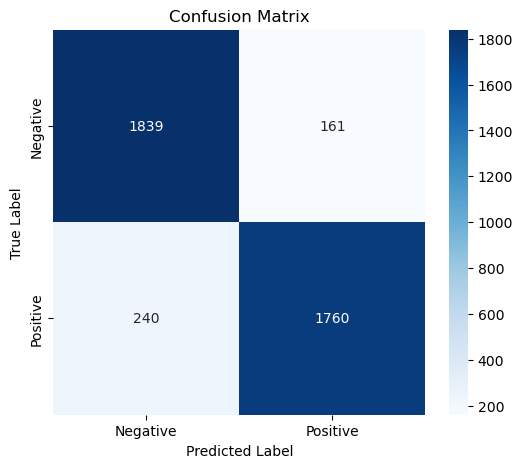

In [44]:
# Cell 9
# ---------------------------------------------------
# Evaluate the CNN model on the test set
# ---------------------------------------------------

y_pred = net.predict(X_test_tensor)

y_test_np = y_test_tensor.numpy()

# Accuracy
test_accuracy = accuracy_score(y_test_np, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred, target_names=["Negative", "Positive"]))

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Negative", "Positive"], 
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


XGBoost Test Accuracy: 0.9050

XGBoost Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.91      0.91      2000
    Positive       0.91      0.90      0.90      2000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.90      4000
weighted avg       0.91      0.91      0.90      4000



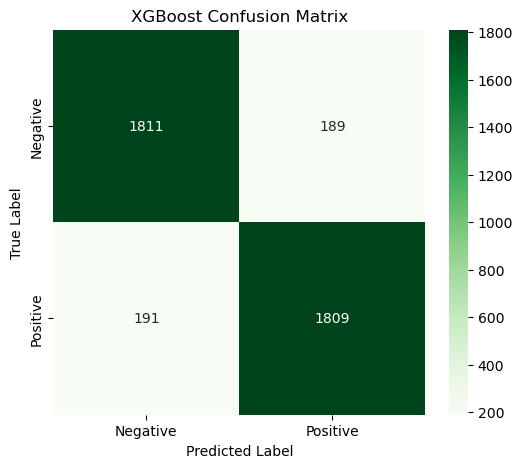

In [45]:
# Cell 10
# ---------------------------------------------------
# Train an XGBoost Classifier on the extracted features
# ---------------------------------------------------

# Create and train the XGBoost model
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=applied_state
)

# Fit on TF-IDF vectors
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Test Accuracy: {test_accuracy_xgb:.4f}")

# Classification Report
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=["Negative", "Positive"]))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", 
            xticklabels=["Negative", "Positive"], 
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix")
plt.show()


In [46]:
# Cell 11
# ---------------------------------------------------
# Save trained models and preprocessing tools
# ---------------------------------------------------

# Save CNN model weights
torch.save(net.module_.state_dict(), "cnn_model.pth")
print("CNN model saved as 'cnn_model.pth'.")

# Save CNN vocabulary
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)
print("Vocabulary saved as 'vocab.pkl'.")

# Save TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
print("TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'.")

# Save XGBoost model
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)
print("XGBoost model saved as 'xgb_model.pkl'.")


CNN model saved as 'cnn_model.pth'.
Vocabulary saved as 'vocab.pkl'.
TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'.
XGBoost model saved as 'xgb_model.pkl'.


In [47]:
# Cell 12
# Classify 10 sample reviews using loaded CNN and XGBoost models

scope_reviews = [
    "This class was a total mess — lectures never made any sense.",
    "Great class! I learned a lot and the professor was very helpful.",
    "I felt like I was teaching myself most of the time.",
    "The group projects were painful but I did enjoy the content.",
    "Clear grading, fair assignments, and useful material. Would recommend.",
    "SCOPE is life-changing... in the worst possible way.",
    "Labs were fun but lectures were a bit slow.",
    "Excellent pacing, feedback was always prompt.",
    "Hard to follow, exams didn't reflect what we learned.",
    "Everything was organized and the TA support was awesome."
]

print("SCOPE Review Predictions:\n")
for review in scope_reviews:
    demo_predict(review, vocab, max_seq_length, net, vectorizer, xgb_model, device)
    print("-" * 80)



SCOPE Review Predictions:

Review: this class was a total mess — lectures never made any sense.
CNN Prediction: Positive
XGBoost Prediction: Negative
--------------------------------------------------------------------------------
Review: great class! i learned a lot and the professor was very helpful.
CNN Prediction: Positive
XGBoost Prediction: Positive
--------------------------------------------------------------------------------
Review: i felt like i was teaching myself most of the time.
CNN Prediction: Negative
XGBoost Prediction: Negative
--------------------------------------------------------------------------------
Review: the group projects were painful but i did enjoy the content.
CNN Prediction: Positive
XGBoost Prediction: Negative
--------------------------------------------------------------------------------
Review: clear grading, fair assignments, and useful material. would recommend.
CNN Prediction: Negative
XGBoost Prediction: Positive
-----------------------------